### Structure factor Calculation
\begin{equation}
S(\vec{q}) =   \frac{1}{N^{2}}\sum_{ij} \langle  S_{i}.S_{j} e^{\iota \vec{q} .(\vec{r_{i}}-\vec{r}_{j})} \rangle
\end{equation}
$ S_{i}.S_{j}$ is the monte carlo average of the spin-spin correlation function.
* The phase factor can further be simplified to,
\begin{equation}
e^{\iota \vec{q}.(\vec{r_{i}}-\vec{r_{j}})} = e^{\iota( q_{x}\delta{x_{ij}} + q_{y}\delta{y_{ij}})}
\end{equation}
* $\delta{x_{ij}} = x_{i}-x_{j}$.
* $\delta{y_{ij}} = y_{i}-y_{j}$.
* The expression can be simplified for a three dimensional vector with component $s_{x},s_{y},s_{z}$ as,
\begin{equation}
\langle S_{i}.S_{j}\rangle =  \langle S_{i,x}S_{j,x} + S_{i,y}S_{j,y} + S_{i,z}S_{y,z}\rangle
\end{equation} 
* The monte carlo averaged quantity can be calculated as,
\begin{equation}
\langle S_{i,k}S_{j,k}\rangle  = \frac{1}{M} \sum_{p=1}^{M} S^{(p)}_{i,k} S^{(p)}_{j,k}
\end{equation}
* Here $p$ is the sum over the different monte-carlo configurations. 
* The sum is performed for all the spin components.

### Antiferromagnetic order parameter
* One can define an anti-ferromagnetic order parameter as,
\begin{equation}
\vec{m}_{\pi,\pi} = \frac{1}{N}\sum_{i}(-1)^{x_{i} + y_{i}}\vec{S}_{i}
\end{equation}
* One can also decouple the order parameter into different components and it can be simplified to,
\begin{equation}
\vec{m}_{\pi,\pi} = \frac{1}{N}\sum_{i}(-1)^{x_{i} + y_{i}}(S_{i,x} + S_{i,y} + S_{i,z})
\end{equation}
\begin{equation}
\vec{m}_{\pi,\pi} = \sum_{\mu=x,y,z} \frac{1}{M} \sum_{m=1}^{M} (S^{(m)}_{\mu})^{2}
\end{equation}
* The component $\mu$ is given by,
\begin{equation}
S^{(m)}_{\mu}  =  \frac{1}{N} \sum_{i}(-1)^{x_{i}+y_{i}}S^{m}_{i,\mu}
\end{equation}
* Summation over the index $m$ represents the monte carlo averages over all the generated configurations.
* $S^{m}_{i,\mu}$ is the value of $S_{\mu}$ component at site $i$ and for the monte carlo sample $m$.


In [1]:
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from itertools import product

In [91]:
def plothist(data,col1,col2,col3,nbins):
    '''
    This function will plot  histograms of the monte carlo data 
        parameters:
            data(dataframe): input dataframe with data
            col1(string): name of first quantity that we want to plot
            col2(string): name of second column that we want to plot
            col3(string): name of third column that we want to plot
            nbins(integer): number of bins 
        return:
            None
    '''
    f,ax=plt.subplots(1,3,figsize=(16,4))
    sns.histplot(data[col1],stat='density',ax=ax[0],\
                     kde=True,element='bars',bins=nbins)
    sns.histplot(data[col2],stat='density',ax=ax[1],\
                  kde=True, element='bars', bins=nbins)
    sns.histplot(data[col3],stat='density',ax=ax[2],\
                 kde=True, element='bars', bins=nbins)
    plt.show()


def boxplot(data, col1,col2,lab1,lab2):
    '''
    This function will plot  boxplots for the monte carlo observable respresented  by column
    col1
        parameters:
            data(dataframe): input dataframe with data
            col1(string): name of first quantity that we want to plot
            col2(string): name of second column that we want to plot
            col3(string): name of third column that we want to plot
        return:
            None
    '''
    sns.catplot(data=data, x=col1, y=col2, kind='box', aspect=3.3, height=4.0)
    plt.xlabel(f'{lab1}',fontsize=14)
    plt.ylabel(r'$%s$'%lab2, fontsize=14)

    plt.show()

    


### class to initialize the variables and functions one need to calculate the structure factor
class StructureFactor:
    def __init__(self,L,filepath):
        ''' 
        This will instantiate an object of type structure factor.
            Parameters:
                L(int): system size
                filepath(string): location where the files are stored
            return :
                L(int) : system size
                n_sites(int) : number of sites in the system
        '''

        self.L = L
        self.n_sites = self.L ** 2
        self.filepath = filepath
    ### function to get the names of file we are interested in 
    def getFile(self):
        ''' 
            this function will get all the files inside the folder that we need
            Parameters:
                object instance: (self)
            
            return :
                dictfile: dictionary containing names of all the files with keys as the temperature values.
        '''
        ### store names of all files inside the folder
        f = os.listdir(self.filepath)
        
        ## file names that we need for calculations also the temperature values
        f_list,temp_list = [],[]
        
        ## loop over all the files in the folder
        for j in f:
            ## choose only files that starts with configurations
            if j.startswith('sephamconfigurations_L8_temp'):
                ## obtain the temperature from the file name
                temp=j.split('temp')[1].split('_Uint')[0]
                ## append the file name
                f_list.append(j)
                ## append the temperature value
                temp_list.append(float(temp))
       
        self.filedict = dict(sorted(dict(zip(temp_list,f_list)).items()))
        

    ## function to load one file. The temperature (key is supplied as an argument)
    
    def loadData(self,ki):
        '''
        This function will load data and puts it in a form that is convenien
        for further use. The file that is to loaded is specified using a temperature
        that is supplied via the user.
            parameters:
                self(instance): Object that is to be used
                ki(key): the key that will be used to load the corresponding file
            return
                df (dataframe): dataframe containing the data of the file 
                    that is loaded
        '''

        tempf = pd.read_csv(self.filepath+self.filedict[ki],header=None,sep='\t')
        tempf.columns = ['data']
        m,theta,phi,temp_i = [],[],[],[]
        for j in range(tempf.shape[0]):
            _,_,m1,m2,m3 = tempf.iloc[j,0].split()
            #print(f'm: {m1} theta: {m2} phi: {m3}')
            m.append(m1)
            theta.append(m2)
            phi.append(m3)
            temp_i.append(ki)
        
        m = np.array(m,dtype='float64')
        theta = np.array(theta,dtype='float64')
        phi = np.array(phi,dtype='float64')
        temp_i = np.array(temp_i)
        temp_df = pd.DataFrame({'temp':temp_i,'m':m, \
                'theta':theta,'phi':phi})

        self.df = temp_df
        print (self.df.shape[0],self.n_sites)
        ## number of monte carlo configurations
        self.nmc = self.df.shape[0]//self.n_sites

    ### convert m,theta,phi data frame into one with component mx,my,mz
    def calc_comp(self):
        '''
        this function will convert the dataframe with m,theta,phi 
        value into a three component vector mx,my,mz.
            parameter:
                self (instance): instance of the class
            return:
                compdf (dataframe): dataframe with the mx,my,mz component of the vector.
        '''
        ## list to store the values of mx,my,mz and temperature
        tempmx,tempmy,tempmz,temp_i = [],[],[],[]

        ## loop over all the entried of the dataframe
        for j in range(self.df.shape[0]):

            temp_i.append(self.df.iloc[j,0])
            m = self.df.iloc[j,1]
            theta = self.df.iloc[j,2]
            phi = self.df.iloc[j,3]
            #print(f'm: {m} theta: {theta} phi: {phi}')

            ### calculating component mx,my,mz using m,theta,phi
            tempmx.append(m*np.cos(phi)*np.sin(theta))
            tempmy.append(m*np.sin(phi)*np.sin(theta))
            tempmz.append(m*np.cos(theta))
        
        temp_i = np.array(temp_i)
        tempmx = np.array(tempmx)
        tempmy = np.array(tempmy)
        tempmz = np.array(tempmz)

        temp_df = pd.DataFrame({'temp':temp_i,'mx':tempmx,'my':tempmy,'mz':tempmz})
        
        self.compdf = temp_df

    ## get the x,y coordinate of the sites in the lattice as well as divide them into
    ## a sublattice
    def lattind(self):
        '''
        This function will calculate the x and y index of each site in the lattice also
        this will calculate and put the sites into either sublattice 1 or sublattice 2
            parameter:
                self(object): instance of the class
            return:
                xind(array): array of x indices of all the sites
                yind(array): array of all y indices
                asublatt(array): array that stores sites in  sublattice A
                bsublatt(array): array that stores sites in sublattice B
                sphase(array): to store the phase of the site based on if it's even or not
        '''
        ## list to store x,y indices and A and B sublattice sites
        tempx,tempy,tempA,tempB,phse = [],[],[],[],[]
        for i in range(self.n_sites):
            xi,yi = i %self.L,i//self.L
            tempx.append(xi)
            tempy.append(yi)
            if ((xi+yi)%2 == 0):
                tempA.append(i)
                phse.append(1)
            elif((xi+yi)%2 !=0):
                tempB.append(i)
                phse.append(-1)
        self.xind = np.array(tempx)
        self.yind = np.array(tempy)
        self.asublatt = np.array(tempA)
        self.bsublatt = np.array(tempB)
        self.sphase = np.array(phse)

    ### function to plot scatter 3d plot of the data
    def plotpx(self,data, col1, col2, col3, col4):
        '''
        This function will plot scatter plot in 3d of given variables
            parameters:
                data(dataframe): the input data frame
                col1(string): name of first column
                col2(string): name of second column
                col3(string): name of third column
                col4(string): name of 4th column (used mainly for size and color)
            return:
                None
        '''
        fig = px.scatter_3d(data, x=col1, y=col2, z=col3, color=col4, size=col4)
        fig.show()
        #self.scatter = fig
   

### function to define the q grid pssible q values
    def qxqyvals(self, qxval, qyval):
        '''
        This function will define the allowed q vector grid also 
        the associated phase matrix
            parameters:
                self: Class instance
                qxval: the qx value that one wants to use
                qyval: qy value that we want to use
            return:
        '''
        #self.qx = np.linspace(0, 2*np.pi,se; L)
        #self.qy = np.linspace(0, 2*np.pi, L)
        delx = np.zeros((self.n_sites, self.n_sites))
        dely = np.zeros((self.n_sites, self.n_sites))
        for i, j in product(np.arange(self.n_sites), np.arange(self.n_sites)):
            xi, yi = i % self.L, i//self.L
            xj, yj = j % self.L, j//self.L
#            delx[i, j] = min(abs(xi-xj),self.L-abs(xi-xj))
#            dely[i, j] = min(abs(yi-yj), self.L-abs(yi-yj))

            delx[i, j] = xi-xj
            dely[i, j] = yi-yj

        self.delx = delx
        self.dely = dely
        qxdict, qydict = {}, {}

        #for j in self.qx:
        #    qxdict[j] = j*delx
        #for j in self.qy:
        #    qydict[j] = j*dely

        qxdict[qxval] = qxval*delx
        qydict[qyval] = qyval*dely
        ## exp(-j(qx*(xi-xj) + qy*(yi-yj)))
        qphase = np.exp(-1j*(qxdict[qxval] + qydict[qyval]))
        self.qxdict = qxdict
        self.qydict = qydict
        self.qphase = qphase

    ### function to calculate correlation function <SiSj>
    def correlationfn(self):
        '''
        This function will calculate the spin spin correlation function for a 
        given component p: 1,2,3 (mx,my,mz)
            parameters:
                self(object):instance of the class
            return:
                None
        '''
        ## monte carlo configurations for the x-component
        mx_ic = self.compdf.iloc[:,1].values.reshape(self.nmc,self.n_sites)

        ## mc configurations for the y-component
        my_ic = self.compdf.iloc[:,2].values.reshape(self.nmc,self.n_sites)
        
        ## mc configurations for the z-component
        mz_ic = self.compdf.iloc[:,3].values.reshape(self.nmc,self.n_sites)

        ## matrix to store sum of all correlation terms
        sum_mat = np.zeros((self.n_sites,self.n_sites),dtype='complex128')

        for j in range(self.nmc):
            
            ## vector to store one row and convert it into row vector
            tempvec1 = mx_ic[j,:].reshape(1,-1)
            tempvec2 = mx_ic[j,:].reshape(-1,1)
            ## correlation matrix <Si Sj> 
            corrmat_x = np.matmul(tempvec2,tempvec1)
            
            tempvec1 = my_ic[j, :].reshape(1, -1)
            tempvec2 = my_ic[j, :].reshape(-1, 1)
            corrmat_y = np.matmul(tempvec2,tempvec1)
            
            tempvec1 = mz_ic[j, :].reshape(1, -1)
            tempvec2 = mz_ic[j, :].reshape(-1, 1)
            corrmat_z = np.matmul(tempvec2,tempvec1)
            
            sum_mat += (corrmat_x + corrmat_y + corrmat_z)*self.qphase
        
        
        return sum_mat.sum()

    
    ### anti-ferromagnetic order parameter
    def opcalc(self):
        '''
        This function will calculate the anti-ferromagnetic order parameter for the 
        data
            parameters: 
                self(object): Instance of the class
            return:
                None
        '''

        tempdfmx = self.compdf.iloc[:,1]
        tempdfmy = self.compdf.iloc[:,2]
        tempdfmz = self.compdf.iloc[:,3]
        
        tempmxi = tempdfmx.values.reshape(self.nmc,self.n_sites)
        tempmyi = tempdfmy.values.reshape(self.nmc,self.n_sites)
        tempmzi = tempdfmz.values.reshape(self.nmc,self.n_sites)

        tempmxi = tempmxi * self.sphase
        tempmyi = tempmyi * self.sphase
        tempmzi = tempmzi * self.sphase

        self.confmx = tempmxi.mean(axis=1)
        self.confmy = tempmyi.mean(axis=1)
        self.confmz = tempmzi.mean(axis=1)
        temp_arr = self.df.temp.unique()*np.ones(self.confmx.shape[0])
        self.confm2 = self.confmx**2 + self.confmy**2 + self.confmz**2 
        self.mcconf_df = pd.DataFrame({'mc_mx':self.confmx,'mc_my':self.confmy\
                        ,'mc_mz':self.confmz,'mc_m2':self.confm2,'temp':temp_arr})




In [3]:

L = 8
## create an instance of the class structure factor
sf = StructureFactor(L, './')
sf.lattind()
## calling the function to get the names of the file
sf.getFile()

print(sf.filedict)

## load data for temp = 0.01
sf.loadData(0.30)
print(sf.nmc)
print(sf.df.head())
 
### calcualte each component
sf.calc_comp()
sf.opcalc()

### scatter plot distribution of m,theta,phi
#sf.plotpx(sf.df, 'm', 'theta', 'phi', 'temp')

### scatter plot of mx,my,mz
#sf.plotpx(sf.compdf, 'mx', 'my', 'mz', 'temp')

#sf.plothist(sf.df,'m','theta','phi')
#sf.plothist(sf.compdf, 'mx', 'my', 'mz')

## construct the q grid
sf.qxqyvals(np.pi, np.pi)

## calculate the spin-spin correlation functin for each component
cm = (1./(sf.nmc*sf.n_sites**2))*sf.correlationfn()

## averaged value of the real component of the structure factor
print(f'real part {cm.real}  imaginary part mean:{cm.imag.mean()}')

#sf.qphase


{0.01: 'sephamconfigurations_L8_temp0.010000_Uint2.000_cluster6', 0.02: 'sephamconfigurations_L8_temp0.020000_Uint2.000_cluster6', 0.03: 'sephamconfigurations_L8_temp0.030000_Uint2.000_cluster6', 0.04: 'sephamconfigurations_L8_temp0.040000_Uint2.000_cluster6', 0.05: 'sephamconfigurations_L8_temp0.050000_Uint2.000_cluster6', 0.06: 'sephamconfigurations_L8_temp0.060000_Uint2.000_cluster6', 0.07: 'sephamconfigurations_L8_temp0.070000_Uint2.000_cluster6', 0.08: 'sephamconfigurations_L8_temp0.080000_Uint2.000_cluster6', 0.09: 'sephamconfigurations_L8_temp0.090000_Uint2.000_cluster6', 0.1: 'sephamconfigurations_L8_temp0.100000_Uint2.000_cluster6', 0.11: 'sephamconfigurations_L8_temp0.110000_Uint2.000_cluster6', 0.12: 'sephamconfigurations_L8_temp0.120000_Uint2.000_cluster6', 0.13: 'sephamconfigurations_L8_temp0.130000_Uint2.000_cluster6', 0.14: 'sephamconfigurations_L8_temp0.140000_Uint2.000_cluster6', 0.15: 'sephamconfigurations_L8_temp0.150000_Uint2.000_cluster6', 0.16: 'sephamconfiguratio

In [4]:
fig = px.scatter_3d(sf.mcconf_df,x='mc_mx',y='mc_my',z='mc_mz',size='mc_m2',color='mc_m2')
fig.show()

### Working with all the files in the folder
* One can also loop over all the configurations at all temperatures.

In [5]:
df_m,df_comp,df_mc = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
L=8
fp='./'
loopobj = StructureFactor(L,filepath=fp)

loopobj.getFile()
crf=[]

for j in loopobj.filedict.keys():
    loopobj.lattind()        
    loopobj.loadData(j)
    loopobj.calc_comp()
    loopobj.opcalc()
    loopobj.qxqyvals(np.pi,np.pi)
    crf.append((1./(loopobj.nmc*loopobj.n_sites**2))*(loopobj.correlationfn()).real)
    print(f'temp: {j}')
    df_comp  = pd.concat([df_comp,loopobj.compdf])
    df_m = pd.concat([df_m,loopobj.df])
    df_mc = pd.concat([df_mc,loopobj.mcconf_df])

strfc_df = pd.DataFrame({'temp': np.array(list(loopobj.filedict.keys())) \
                ,'sf': np.array(crf)})




12800 64
temp: 0.01
12800 64
temp: 0.02
12800 64
temp: 0.03
12800 64
temp: 0.04
12800 64
temp: 0.05
12800 64
temp: 0.06
12800 64
temp: 0.07
12800 64
temp: 0.08
12800 64
temp: 0.09
12800 64
temp: 0.1
12800 64
temp: 0.11
12800 64
temp: 0.12
12800 64
temp: 0.13
12800 64
temp: 0.14
12800 64
temp: 0.15
12800 64
temp: 0.16
12800 64
temp: 0.17
12800 64
temp: 0.18
12800 64
temp: 0.19
12800 64
temp: 0.2
12800 64
temp: 0.21
12800 64
temp: 0.22
12800 64
temp: 0.23
12800 64
temp: 0.24
12800 64
temp: 0.25
12800 64
temp: 0.26
12800 64
temp: 0.27
12800 64
temp: 0.28
12800 64
temp: 0.29
12800 64
temp: 0.3


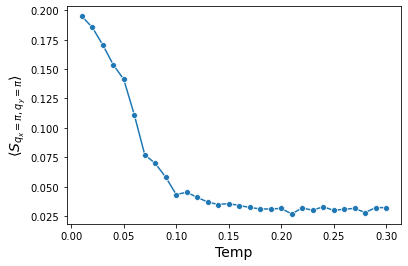

In [12]:
sns.lineplot(x='temp',y='sf',data=strfc_df,markers=True,marker='o')
plt.xlabel('Temp',fontsize=14)
plt.ylabel(r'$\langle S_{q_{x} = \pi, q_{y}=\pi}\rangle$', fontsize=14)
plt.show()
strfc_df.to_csv(loopobj.filepath+'magstrucfac_L8.csv',index=[0])

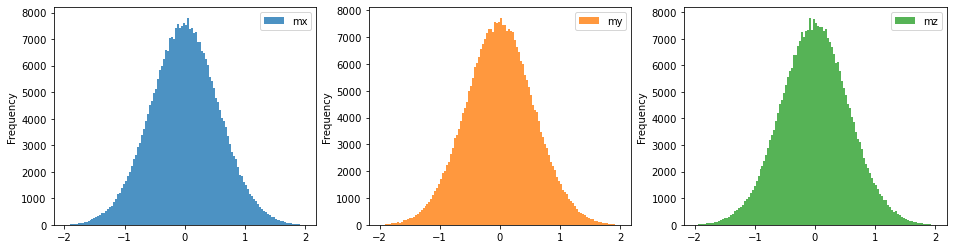

In [77]:
df_comp.iloc[:,1:].plot(kind='hist',subplots=True,layout=(1,3) \
    ,figsize=(16,4),bins=120,alpha=0.8)
plt.show()

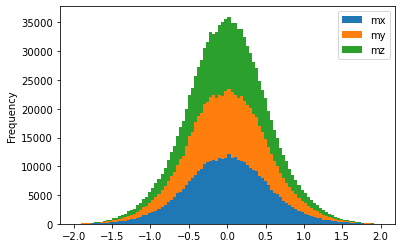

In [41]:
df_comp.iloc[:, 1:].plot(kind='hist',stacked=True,bins=100,)
plt.show()

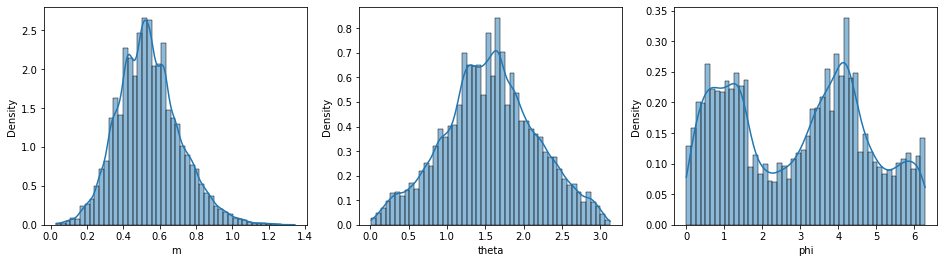

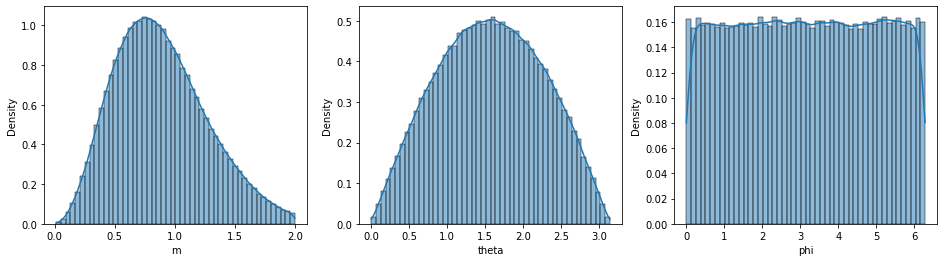

In [82]:
plothist(df_m[df_m.temp<=0.04],'m','theta','phi',nbins=50)
plothist(df_m[df_m.temp>0.04], 'm', 'theta', 'phi', nbins=50)


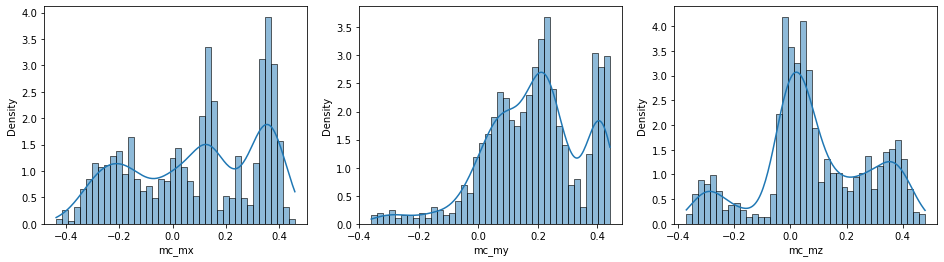

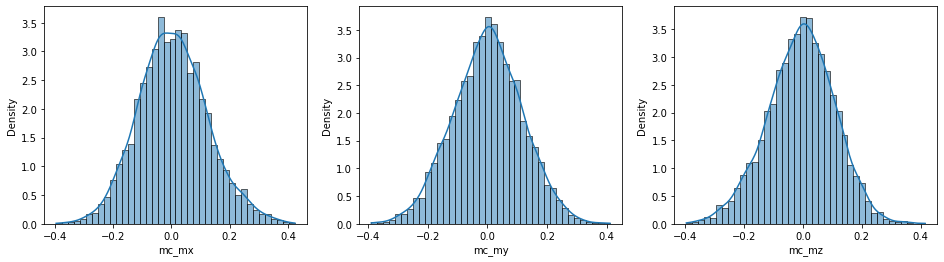

In [85]:
plothist(df_mc[df_mc.temp<=0.05],'mc_mx','mc_my','mc_mz',40)
plothist(df_mc[df_mc.temp>0.05],'mc_mx','mc_my','mc_mz',40)

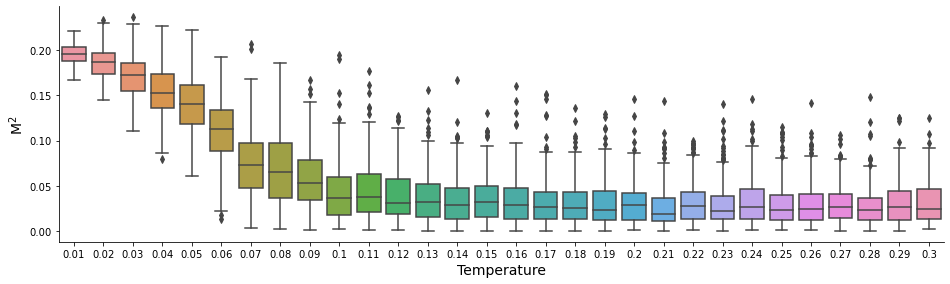

In [94]:
#boxplot(df_m,'temp','theta')
#boxplot(df_m,'temp','phi')
#boxplot(df_comp,'temp','mx')
#boxplot(df_comp,'temp','my')
#boxplot(df_comp,'temp','mz')
lab1 = 'Temperature'
lab2 = ' \mathrm{M}^{2} '
boxplot(df_mc,'temp','mc_m2',lab1,lab2)


ValueError: cannot reindex from a duplicate axis

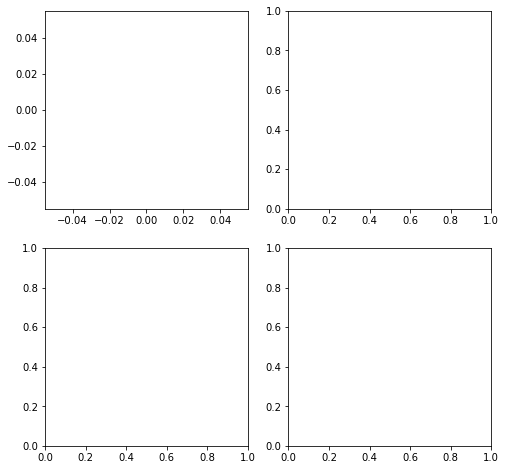

In [39]:
f,ax = plt.subplots(2,2,figsize=(8,8))

sns.lineplot(x='temp', y='mc_mx', data=df_mc, ax=ax[0, 0]\
                ,label=r'$\langle m_{x} \rangle $')
sns.lineplot(x='temp',y='mc_my',data=df_mc,ax=ax[0,1]\
                ,label=r'$\langle m_{y} \rangle $')
sns.lineplot(x='temp',y='mc_mz',data=df_mc,ax=ax[1,0]\
                ,label=r'$\langle m_{z} \rangle $')
sns.lineplot(x='temp',y='mc_m2',data=df_mc,ax=ax[1,1]\
                ,label=r'$\langle m^{2} \rangle $')

plt.tight_layout()
plt.show()


In [13]:
fig = px.scatter_3d(df_mc, x='mc_mx', y='mc_my',
                    z='mc_mz', size='mc_m2', color='temp')
fig.show()


### Data from old structure factor calculation


In [23]:
fU2mag = pd.read_csv('U2.0/magnetic_sq_ptca_test_L24_Lc6_U2.0.dat',sep='\t',header=None)
fU3mag = pd.read_csv('U3.0/magnetic_sq_ptca_test_L24_Lc6_U3.0.dat',sep='\t',header=None)
fU4mag = pd.read_csv('U4.0/magnetic_sq_ptca_test_L24_Lc6_U4.0.dat',sep='\t',header=None)
fU5mag = pd.read_csv('U5.0/magnetic_sq_ptca_test_L24_Lc6_U5.0.dat',sep='\t',header=None)
fU6mag = pd.read_csv('U6.0/magnetic_sq_ptca_test_L24_Lc6_U6.0.dat',sep='\t',header=None)


datacol = ['temp', 'sf']
fU2mag.columns = datacol
fU2mag['U'] = 2*np.ones(fU2mag.shape[0])
fU3mag.columns = datacol
fU3mag['U'] = 3*np.ones(fU3mag.shape[0])
fU4mag.columns = datacol
fU4mag['U'] = 4*np.ones(fU4mag.shape[0])
fU5mag.columns = datacol
fU5mag['U'] = 5*np.ones(fU5mag.shape[0])
fU6mag.columns = datacol
fU6mag['U'] = 6*np.ones(fU6mag.shape[0])
data_df = pd.concat([fU2mag, fU3mag, fU4mag, fU5mag, fU6mag])


### Data from new Structure factor calculation


In [60]:
dfU2 = pd.read_csv('U2.0/magstrucfac.csv',index_col=[0]);dfU2['U'] = 2*np.ones(dfU2.shape[0])
dfU3 = pd.read_csv('U3.0/magstrucfac.csv',index_col=[0]);dfU3['U'] = 3*np.ones(dfU3.shape[0])
dfU4 = pd.read_csv('U4.0/magstrucfac.csv',index_col=[0]);dfU4['U'] = 4*np.ones(dfU4.shape[0])
dfU5 = pd.read_csv('U5.0/magstrucfac.csv',index_col=[0]);dfU5['U'] = 5*np.ones(dfU5.shape[0])
dfU6 = pd.read_csv('U6.0/magstrucfac.csv',index_col=[0]);dfU6['U'] = 6*np.ones(dfU6.shape[0])


In [64]:
data2_df = pd.concat([dfU2,dfU3,dfU4,dfU5,dfU6])

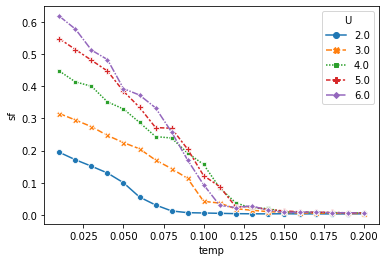

In [54]:
palette = sns.color_palette("tab10",5)

sns.lineplot(x='temp',y='sf',hue='U',data=data_df,\
             markers=True,style='U',palette=palette)
             
plt.show()



In [72]:
data2_df['Calc'] = 'new'
data_df['Calc']='old'
combined_df = pd.concat([data_df,data2_df])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


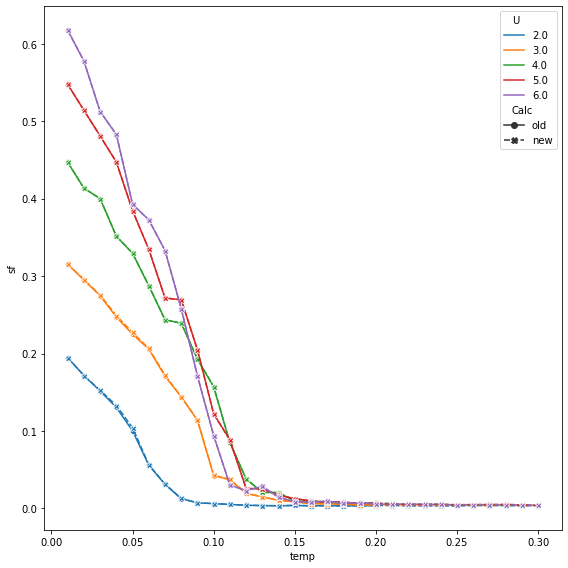

In [103]:
f = plt.figure(figsize=(8,8))
palette = sns.color_palette("tab10", 5)

sns.lineplot(x='temp',y='sf',hue='U',data=combined_df,\
                markers=True,palette=palette,style='Calc')
plt.savefig('output.eps',dpi=400)
plt.tight_layout()
plt.show()
